# ネットワーク可制御性（最大マッチングに基づく）

networkxの読み込み

In [1]:
import networkx as nx

その他ライブラリ

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 20.7 MB/s eta 0:00:00


In [4]:
import pulp

In [5]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.3 MB/s eta 0:00:00


In [6]:
import igraph as ig

マッチングに基づいてドライバーノードを求めるための関数

In [7]:
def get_mds_matching(g, relax=False):
  # Handle edge weights
  for e in g.edges():
    if 'weight' not in g[e[0]][e[1]]:
        g[e[0]][e[1]]['weight'] = 1.0

  # Handle node names
  mapping = {old: i for i, old in enumerate(g.nodes())}
  g = nx.relabel_nodes(g, mapping)

  # Get edge list and create optimization problem
  edge_list = list(g.edges())
  n_nodes = g.number_of_nodes()
  n_edges = g.number_of_edges()

  # Create LP problem
  prob = pulp.LpProblem("MaximumMatching", pulp.LpMaximize)

  # Decision variables
  if relax:
    x = pulp.LpVariable.dicts("edge", range(n_edges), lowBound=0, upBound=1)
  else:
    x = pulp.LpVariable.dicts("edge", range(n_edges), cat='Binary')

  # Objective function
  prob += pulp.lpSum([x[i] * g[edge_list[i][0]][edge_list[i][1]]['weight'] for i in range(n_edges)])

  # Constraints
  for i in range(n_nodes):
    # Out-degree constraints
    prob += pulp.lpSum([x[j] for j in range(n_edges) if edge_list[j][0] == i]) <= 1
    # In-degree constraints
    prob += pulp.lpSum([x[j] for j in range(n_edges) if edge_list[j][1] == i]) <= 1

  # Solve the problem
  prob.solve()

  # Get matching solution
  matching_links = [round(x[i].value()) for i in range(n_edges)]

  # Find driver nodes
  matched_nodes = set(edge_list[i][1] for i in range(n_edges) if matching_links[i] == 1)
  driver_nodes = [1 if node not in matched_nodes else 0 for node in range(n_nodes)]

  return {
    "minimum driver node set size": sum(driver_nodes),
    "is driver node": driver_nodes,
    "is matching link": matching_links
  }

## ネットワークの読み込み
モデルネットワークを例にする。

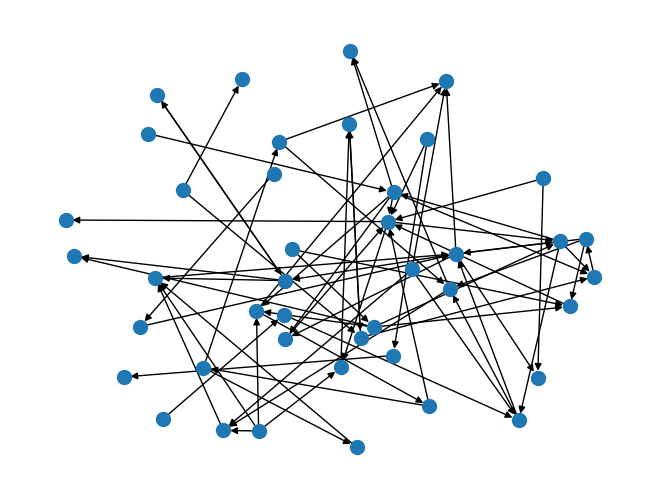

In [8]:
random.seed(123)
g = ig.GraphBase.Static_Power_Law(50, 70, 2.1, 2.1)
# igraph to networkx
edgelist = g.get_edgelist()
g = nx.DiGraph(edgelist)

# ネットワークの表示
pos = nx.spring_layout(g, k=1.0, seed=123)
nx.draw(g, node_size=100, pos=pos)

## ネットワークのドライバノードを見つける
最小ドライバーノード集合（minimum driver node set）を得る

In [9]:
mds = get_mds_matching(g, relax = False)
# relax: 論理値，バイナリ整数計画問題を線形計画緩和するかどうか。デフォルトはFalse（しない）。

結果にアクセスする

In [10]:
# 最小ドライバーノード集合のサイズ
mds["minimum driver node set size"]

11

In [ ]:
# ドライバノードメンバーシップ: ドライバノードである (1) でない (0)
mds["is driver node"]

In [ ]:
# マッチングリンクのメンバーシップ: マッチングリンクである (1) ない (0)
mds["is matching link"]

結果の表示

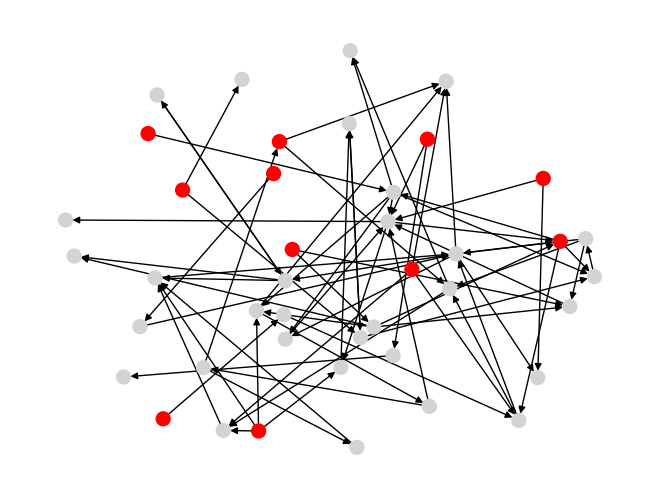

In [13]:
# ノードの色を設定（ドライバーノードは赤、それ以外は青）
node_colors = ['red' if x == 1 else 'lightgray' for x in mds["is driver node"]]
nx.draw(g, node_size=100, pos=pos, node_color=node_colors)

## ネットワーク可制御性に基づいてノードを「不必要」「中立」「不可欠」に分類する。
関数の準備

In [14]:
def node_classification_controllability(g, get_mds=get_mds_matching, relax=False):
  # ノードの分類
  node_class = []
  # 元のグラフでの最小ドライバーノードセットのサイズ
  mds_original = get_mds(g, relax)["minimum driver node set size"]

  # 各ノードについて処理
  for v in g.nodes():
    # ノードvを削除したグラフを作成
    g_del = g.copy()
    g_del.remove_node(v)

    # 削除後のグラフでの最小ドライバーノードセットのサイズ
    mds_del = get_mds(g_del, relax)["minimum driver node set size"]

    # ノードの分類
    if mds_original == mds_del:
        node_class.append("neutral")
    elif mds_original < mds_del:
        node_class.append("indispensable")
    else:  # mds_original > mds_del
        node_class.append("dispensable")

  return node_class

分類を得る

In [15]:
classifications = node_classification_controllability(g, get_mds = get_mds_matching, relax = False)

結果を表示する

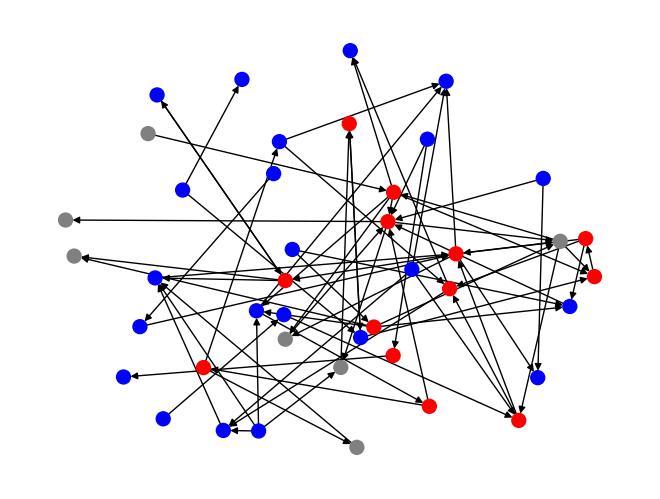

In [16]:
# 分類に基づく色分け
color_map = {
    "neutral": "blue",
    "indispensable": "red",
    "dispensable": "gray"
}
node_colors = [color_map[c] for c in classifications]

# ネットワークの表示
nx.draw(g, pos=pos, node_size=100, node_color=node_colors)

# やってみよう
* このNotebookを参考にして，生物ネットワークを解析してみよう（`data`に様々ある）。
* Notebookを参考に自分のデータを解析してみよう。